In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("D:\\문서파일들\\2022-1\\국비지원 교육 211213-220519\\final project\\Data\\0425_ENG_final_drama_reviews.csv")

In [2]:
titles = df.groupby('title',as_index=False).count().title
titles

0                          18어게인
1                  365:운명을거스르는1년
2                       60일지정생존자
3                           D.P.
4     검색어를입력하세요WWW
                 ...            
87                  하늘에서내리는일억개의별
88                          하이에나
89                      한번다녀왔습니다
90                          해피니스
91                         호텔델루나
Name: title, Length: 92, dtype: object

In [3]:
reviews = df.reviews.to_list()
sentences = ",".join(reviews)

# 필요 함수들

In [ ]:
pip install contextualized_topic_models

In [4]:
import re
import pandas as pd
import numpy as np
import string
from tensorflow.keras.preprocessing.text import text_to_word_sequence
import nltk
import spacy
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
# from contextualized_topic_models.models.ctm import CombinedTM
# from contextualized_topic_models.utils.data_preparation import TopicModelDataPreparation, bert_embeddings_from_list
from contextualized_topic_models.utils.preprocessing import WhiteSpacePreprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# from konlpy.tag import Okt
from tqdm import tqdm

In [5]:
from nltk.corpus import stopwords
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
stop_words = set(stopwords.words('english'))
stop_words.update(('\r\n', '\n\r', 'ever', 'much', 'look', 'squid', 'show', 'thing', "i've", 'anything', 'something', "show's",
                   'www', 'soompi' 'com', 'instagram', 'youtube', 'https', 'mydramalist', 'twitter', 'episode', 'comment', 'scene',
                   'version', "he's", 'gonna', 'series', 'watch', 'everything', 'something', "can't", 'list', 'dramas', 'drama',
                   'wait', 'preview', 'someone', 'everyone', 'dont', 'think', 'season', 'anyone', 'something', 'anything', 'nothing', 'world',
                   'status', 'week', 'name', 'cause', 'time', 'en', 'org', 'wikipedia', 'wiki', 'pbs', 'twimg', 'year', 'point', 'please', 'today',
                   'haha', 'case', 'guess', 'reason', 'person', 'moment', 'sense', 'kinda', 'part', 'movie', 'school', 'start', 'work', 'lead', 'kind',
                   'rate', 'rating', 'rate', 'men', 'example', 'idea', 'half', 'review', 'genre', 'side', "that's", "they're", 'till', 'tell', 'phone',
                   'section', 'number', 'company', 'line', "there's", 'male', 'team', 'rating', 'baby', 'course', 'care', 'cute', 'question', 'help', 'group',
                   'hand', 'spoiler', 'hate', 'need', 'mess', 'change', 'drop', 'date', 'netflix', 'yeah', 'daon', 'park', 'thank', 'lmao', 'damn', "i'll",
                   'kang', 'shinwoo', 'taekyung', 'mean', 'woman', 'hope', 'read', 'fact', 'opinion', 'stuff', 'feel', 'kdrama', 'talk', 'song', 'hype',
                   'title', 'type'))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\g8428\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\g8428\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\g8428\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\g8428\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# 사용 함수

In [6]:
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('V'):
        return 'v'
    elif pos_tag.startswith('N'):
        return 'n'
    elif pos_tag.startswith('J'):
        return 'a'
    elif pos_tag.startswith('R'):
        return 'r'
    else:
        return None

# CustomTokenizer class setting

In [7]:
class CustomTokenizer:
    def __init__(self, tagger):
        self.tagger = tagger
    def __call__(self, a):
        a = ' '.join(a).lower()
        word_tokens = self.tagger(a)
        
        words = []
        for i in word_tokens:
            text = re.sub('[^a-zA-Z0-9\']','',i).strip()
            text = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`…》]','', text)
            if(text != ''):
                words.append(text)
        
        tag_words = nltk.pos_tag(words)
        pos_words = [word for word in tag_words if word[1][0] in {'N'}] #'V','N','J','R'

        temp_list = []
        for token, pos_tag in pos_words:
            tag = get_wordnet_pos(pos_tag)
            if tag != None:
                temp_list.append((token, get_wordnet_pos(pos_tag)))
        lemma = WordNetLemmatizer()
        token_final = [lemma.lemmatize(token, pos=tag) for token, tag in temp_list]
        long_words = [i for i in token_final if len(i) > 2]
        results = [w for w in long_words if w not in stop_words]
        return results

# 작업

In [8]:
def tfidf_vectorizing(reviews):
    ngram_range = (1,1)

    custom_tokenizer = CustomTokenizer(text_to_word_sequence)
    custom_tokenizer(sentences)

    tfidf = TfidfVectorizer(tokenizer=custom_tokenizer,ngram_range = ngram_range, stop_words=stop_words,
                            max_df=10, min_df=2,max_features=5000).fit(reviews)
    candidates = tfidf.get_feature_names()
    return candidates

# 임베딩

In [9]:
def embedding(sentences,candidates):
    from sentence_transformers import SentenceTransformer

    model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')
    # doc_embedding = model.encode([sentence])
    doc_embedding = model.encode([sentences])
    candidate_embeddings = model.encode(candidates)
    
    return doc_embedding, candidate_embeddings

# 코사인 유사도 함수

In [10]:
from sklearn.metrics.pairwise import cosine_similarity
top_n = 500
diversity = 0.6

def mmr(doc_embedding, candidate_embeddings, words, top_n, diversity):
    word_doc_distances = cosine_similarity(candidate_embeddings,doc_embedding)
    word_distances = cosine_similarity(candidate_embeddings) 

    keywords_idx = [np.argmax(word_doc_distances)]
    candidates_idx = [i for i in range(len(candidates)) if i != keywords_idx[0]]
    
    for _ in range(top_n-1):
        try:
        # 후보 키워드들의 문서유사도 값
            candidate_similarities = word_doc_distances[candidates_idx, :]
            # 후보 키워드와 가장 유사한 키워드
            target_similarities = np.max(word_distances[candidates_idx][:,keywords_idx], axis=1) 

            mmr = (1-diversity) * candidate_similarities - diversity * target_similarities.reshape(-1,1)
            mmr_idx = candidates_idx[np.argmax(mmr)]

            keywords_idx.append(mmr_idx)
            candidates_idx.remove(mmr_idx)
        except:
            break

    # 본 단어 임베딩벡터에서 추출키워드에 해당하는 벡터만
    keywords_vector = candidate_embeddings[keywords_idx][:] 
    keywords = [words[idx] for idx in keywords_idx]
    
    return keywords, keywords_vector


### keyword Dataframe 생성

In [ ]:
import pickle

# drama titles in csv
drama_titles = df.groupby('title',as_index=False).count().title

output = pd.DataFrame(None,columns=drama_titles)

top_n = 500
diversity = 0.6

for title in drama_titles:
    reviews = df[df.title == title].reviews.to_list()
    # tfidf custom vectorizing
    candidates = tfidf_vectorizing(reviews) # reviews = list

    # embedding
    sentences = ','.join(reviews)
    doc_embedding, candidate_embeddings = embedding(sentences, candidates) 

    # keywords extraction

    keywords, keywords_vector = mmr(doc_embedding,candidate_embeddings,candidates,top_n,diversity)

    with open(f'{title}.pickle', 'wb') as f:
        pickle.dump(keywords, f, pickle.HIGHEST_PROTOCOL)
        pickle.dump(keywords_vector, f, pickle.HIGHEST_PROTOCOL)

    output[title] = keywords[:7]

output = output.T

output.to_csv('D:\\문서파일들\\2022-1\\국비지원 교육 211213-220519\\final project\\Data')

In [ ]:
# with open('title.pickle', 'rb') as f:
#     keywords = pickle.load(f)
#     keywords_vector = pickle.load(f)

In [39]:
list(key_dict.items())[-1]

('검색어를입력하세요WWW',
 ['romance irritating',
  'sunbae life',
  'jung actor',
  'game gun',
  'pianist girl',
  'reservation honest',
  'spotify com'])

# KMEANS - 작품별 연관키워드 뽑을 때 사용

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

X = keywords_vector

true_k = 6
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X.T)

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = keywords # = candidates
for i in range(true_k):
    print("["),
    for ind in order_centroids[i, :20]:
        print(f'"{terms[ind]}"', end=",")
    print("],\n")

Top terms per cluster:
[
"way","perfect","really","able","good","also","anything","seem","let","find","make","take","first","south","add","soo","adopt","pas","bit","try",],

[
"kill husband","prison daughter","husband","eun soo","mother law","prison","mother daughter","romance","eun","kill","accuse kill","emotional drama","father","daughter adopt","mother","law","daughter","good story","heart","soo",],

[
"really","take","lot","bit","let","seem","also","way","deeply","accuse","first","good","anything","scene","find","make","series","plot","drama","story",],

[
"mother daughter","daughter","mother","mother law","daughter adopt","prison daughter","eun","eun soo","emotional","emotional drama","reporter","romance","story","drama","adopt","good story","character","spoiler","plot twist","mystery",],

[
"prison daughter","reporter","kill husband","mother daughter","daughter adopt","husband","mother law","mother","daughter","prison","viewer","eun soo","friend","father","character","romance","t

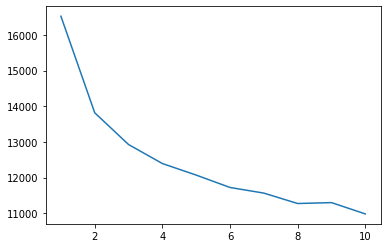

In [ ]:
x = list(range(1,11))
y = []
for i in x:
    model = KMeans(n_clusters=i, init='k-means++', max_iter=100, n_init=1)
    model.fit(X.T)
    y.append(model.inertia_)

import matplotlib.pyplot as plt

plt.plot(x,y,label='linear')
plt.show();